In [47]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, GATConv, GINConv
import pandas as pd
import json
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import os

In [48]:
import json

file_path = "git_web_ml/musae_git_features.json"

with open(file_path, "r") as f:
    features_dict = json.load(f)

# Number of nodes
N = len(features_dict)

# Find maximum feature index across all nodes
max_index = 0
for feature_list in features_dict.values():
    if len(feature_list) > 0:
        max_index = max(max_index, max(feature_list))

# Total feature dimension
D = max_index + 1

print("Number of nodes (N):", N)
print("Feature dimension (D):", D)


Number of nodes (N): 37700
Feature dimension (D): 4005


In [49]:
import torch

row_indices = []
col_indices = []

for node_id, feature_list in features_dict.items():
    node = int(node_id)
    for feature_idx in feature_list:
        row_indices.append(node)
        col_indices.append(feature_idx)

values = torch.ones(len(row_indices), dtype=torch.float)

indices = torch.tensor([row_indices, col_indices], dtype=torch.long)

x = torch.sparse_coo_tensor(
    indices,
    values,
    size=(N, D)
)

print("Sparse feature matrix shape:", x.shape)
print("Number of non-zero entries:", x._nnz())


Sparse feature matrix shape: torch.Size([37700, 4005])
Number of non-zero entries: 690374


In [50]:
import pandas as pd
import torch

edge_path = "git_web_ml/musae_git_edges.csv"

edges = pd.read_csv(edge_path)

# Convert to tensor
edge_index = torch.tensor(
    edges.values.T,
    dtype=torch.long
)

print("Edge index shape:", edge_index.shape)
print("Number of edges:", edge_index.shape[1])


Edge index shape: torch.Size([2, 289003])
Number of edges: 289003


In [51]:
import torch

# edge_index shape: [2, E]
row = edge_index[0]

# Count degree of each node
degree = torch.bincount(row, minlength=N)

print("Min degree:", degree.min().item())
print("Max degree:", degree.max().item())
print("Average degree:", degree.float().mean().item())


Min degree: 0
Max degree: 6809
Average degree: 7.665862083435059


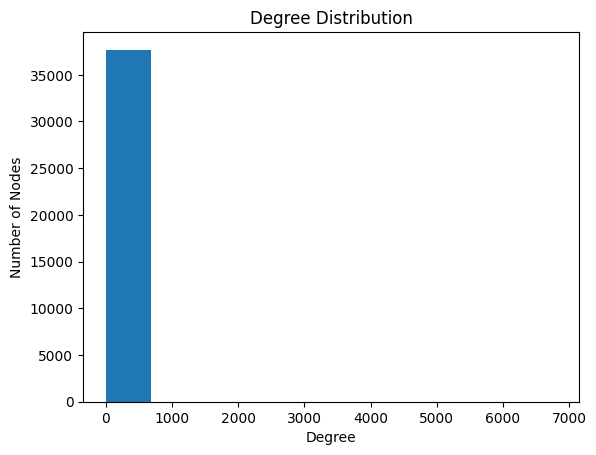

In [52]:
import matplotlib.pyplot as plt

deg_np = degree.numpy()

plt.figure()
plt.hist(deg_np, bins=10)
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution")
plt.show()


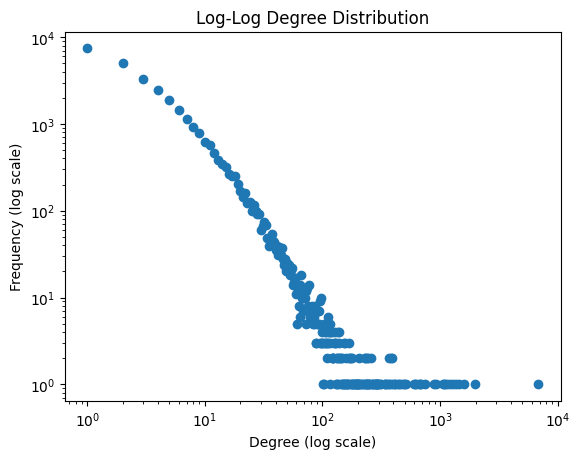

In [53]:
import numpy as np

# Count frequency of each degree value
unique_deg, counts = np.unique(deg_np, return_counts=True)

plt.figure()
plt.loglog(unique_deg, counts, marker='o', linestyle='none')
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Log-Log Degree Distribution")
plt.show()


In [54]:
import networkx as nx

# Convert edge_index to list of edges
edge_list = edge_index.t().tolist()

# Build undirected graph
G = nx.Graph()
G.add_edges_from(edge_list)

print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())


Number of nodes in G: 37700
Number of edges in G: 289003


In [55]:
import community as community_louvain

# Run Louvain
partition = community_louvain.best_partition(G)

# partition: dict {node_id → community_id}

num_communities = len(set(partition.values()))

print("Number of communities:", num_communities)


Number of communities: 91


In [56]:
modularity = community_louvain.modularity(partition, G)
print("Modularity score:", modularity)


Modularity score: 0.4407413651896657


In [57]:
from collections import Counter
import numpy as np

# Count nodes per community
community_sizes = Counter(partition.values())

sizes = np.array(list(community_sizes.values()))

print("Number of communities:", len(sizes))
print("Min community size:", sizes.min())
print("Max community size:", sizes.max())
print("Mean community size:", sizes.mean())
print("Median community size:", np.median(sizes))


Number of communities: 91
Min community size: 2
Max community size: 10253
Mean community size: 414.2857142857143
Median community size: 3.0


In [58]:
import torch

# Extract unique community IDs
unique_comms = sorted(set(partition.values()))

# Create mapping: old_id → new_contiguous_id
comm_map = {old_id: new_id for new_id, old_id in enumerate(unique_comms)}

# Build label tensor
community_labels = torch.zeros(N, dtype=torch.long)

for node in range(N):
    community_labels[node] = comm_map[partition[node]]

print("Community label tensor shape:", community_labels.shape)
print("Number of unique communities:", community_labels.unique().numel())


Community label tensor shape: torch.Size([37700])
Number of unique communities: 91


In [59]:
from collections import defaultdict

community_to_nodes = defaultdict(list)

for node in range(N):
    comm_id = community_labels[node].item()
    community_to_nodes[comm_id].append(node)

print("Number of communities:", len(community_to_nodes))


Number of communities: 91


In [60]:
for comm_id in community_to_nodes:
    community_to_nodes[comm_id] = torch.tensor(
        community_to_nodes[comm_id],
        dtype=torch.long
    )

# Example check
for k in list(community_to_nodes.keys())[:3]:
    print(f"Community {k} size:", community_to_nodes[k].shape[0])


Community 0 size: 1955
Community 1 size: 7427
Community 4 size: 10253


In [62]:
import random

community_ids = list(community_to_nodes.keys())

def sample_triplet():
    # Choose community uniformly
    comm = random.choice(community_ids)

    nodes_in_comm = community_to_nodes[comm]

    # Ensure at least 2 nodes exist
    if len(nodes_in_comm) < 2:
        return sample_triplet()

    # Sample anchor and positive
    anchor, positive = random.sample(nodes_in_comm.tolist(), 2)

    # Sample negative from different community
    neg_comm = random.choice([c for c in community_ids if c != comm])
    negative = random.choice(community_to_nodes[neg_comm].tolist())

    return anchor, positive, negative


In [63]:
a, p, n = sample_triplet()

print("Anchor:", a)
print("Positive:", p)
print("Negative:", n)

print("Anchor community:", community_labels[a].item())
print("Positive community:", community_labels[p].item())
print("Negative community:", community_labels[n].item())


Anchor: 37592
Positive: 30854
Negative: 5390
Anchor community: 0
Positive community: 0
Negative community: 25


In [61]:
class PyG_GAT(nn.Module):
    def __init__(self, F_in, F_hidden, F_out, heads = 8):
        super().__init__()
        self.gat1 = GATConv(F_in, F_hidden, heads=heads, concat=True)
        self.gat2 = GATConv(F_hidden*heads, F_out, heads=1, concat=False)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return x